<a href="https://colab.research.google.com/github/mofuoku417/univariate_time_series_forecasting_of_crude_palm_oil_price_using_deep_learning/blob/main/NN_MODPLOY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Objective
Crude palm oil is a leading commodity from Indonesia. Therefore, accurate prediction of crude palm oil prices is crucial to ensure future prices and help decision making. However, in recent years, high volatility in palm oil prices has become a significant challenge for the industry. This high price variability presents a challenge in predicting the CPO. Therefore, an investigation on crude palm oil prices is needed to anticipate fluctuations. In this analysis, a prediction model was made using ARIMA,  Multilayer Perceptron and Long Short-Term Memory, and Recurrent Neural Network. The four models' performances were compared using the smallest RMSE and MAPE scores.



##Data
In this study, the monthly crude price of oil (CPO) from January 2006 to March 2021 were taken from http: //www.indexmundi.com. 

##Approach

1. Load raw crude palm oil data
2. Perform exploratory data analysis (EDA)
3. Split the data into training data and testing data. 
4. Create a naive prediction
5. Develop an ARIMA model
6. Apply deep learning techniques to the time series data
  *  Scale the data into a range of 0 to 1
  *  Create model architecture for Multilayer Perceptron and Long Short-Term Memory, recurrent neural network
  *  Search for the best hyperparameters for the individual model
  *  Conduct training on an individual model made using the obtained hyperparameters
  *  Pick the most suitable model based on the RMSE value in the training data.
  *  Create predictions on the testing data using the best model
  *  De-normalize the predicted data
  *  Compare the predictions from ARIMA, MLP, LSTM, and RNN based on RMSE and MAPE.
7. Conclusion

In [ ]:
#!ls /bin

###Install Dependencies

In [1]:
!pip install pandas_bokeh
!pip install sklearn
!pip install pyramid
!pip install pmdarima
!pip install pyramid-arima
!pip install pyramid.arima
!pip uninstall statsmodels 
!pip install statsmodels
!pip install bokeh
!pip install pycodestyle pycodestyle_magic
!pip install flake8

     |████████████████████████████████| 246 kB 5.1 MB/s 
     |████████████████████████████████| 251 kB 52.1 MB/s 
     |████████████████████████████████| 114 kB 47.5 MB/s 
     |████████████████████████████████| 1.4 MB 5.0 MB/s 
     |████████████████████████████████| 9.8 MB 42.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 515 kB 5.2 MB/s 
  ERROR: Failed building wheel for pyramid-arima
  Running setup.py clean for pyramid-arima
Failed to build pyramid-arima
    Running setup.py install for pyramid-arima ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-cmezfgey/pyramid-arima_f5eb88dc5c8147eab57f795ef8f78463/setup.py'"'"'; __file__='"'"'/tmp/pip-install-cmezfgey/pyramid-arima_f5eb88dc5c8147eab57f795ef8f

## Load the Libraries

In [2]:
import plotly.express as px
import numpy as np
import cv2
import pickle
import math
import shutil
import pickle
import pandas_bokeh 
from scipy import stats
import plotly.graph_objects as go
import matplotlib.dates as mdates
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from pmdarima.arima import auto_arima
from scipy import stats
from datetime import datetime
from time import time
from bokeh.io import export_svgs
from statsmodels.graphics import tsaplots
import os
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.tsa as sm 
from sklearn import metrics
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterGrid
from keras import optimizers, initializers
from tensorflow.keras import optimizers
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from keras.layers import Dense, LSTM, Activation, Bidirectional, Flatten, TimeDistributed, SimpleRNN, Dropout, GRU, Input, Add, Multiply
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

In [3]:
validation_split = 0.25 

###Define Functions to Add time Features to the Models

In [4]:
def create_time_features(series, target=None):
    """
    Creates time-series features from Datetime index
    """
    series['Date'] = series.index
    X = series.drop(['Date'], axis=1)
    if target:
        y = series[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

###Define Functions to Facilitate Metrics Evaluation

In [5]:
'''
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse
'''
#Calculate the root mean squared error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

#Calculate the mean absolute percentage error
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    return mape

##Load Data from Github

In [33]:
series = pd.read_csv("https://raw.githubusercontent.com/mofuoku417/univariate_time_series_forecasting_of_crude_palm_oil_price_using_deep_learning/main/data.csv")

In [9]:
series.head(20)

,Date,cpo_pri
0,1996-09,545.0
1,1996-10,532.0
2,1996-11,550.0
3,1996-12,561.0
4,1997-01,567.0
5,1997-02,580.0
6,1997-03,559.0
7,1997-04,562.0
8,1997-05,553.0
9,1997-06,533.0


In [34]:
date_rng = pd.date_range(start='2002-02', end='2021-08', freq='MS')
series['Date'] = pd.DataFrame(date_rng, columns=['Date'])

In [35]:
series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     235 non-null    datetime64[ns]
 1   cpo_pri  300 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.8 KB


###Plot the Target Variable

In [36]:
import plotly.express as px
from plotly.validators.scatter.marker import SymbolValidator
# plotly
fig = px.line(series, x='Date', y='cpo_pri')
fig.update_layout(title_text='Monthly Crude Palm Oil Price', title_x=0.5)
fig.write_html("TarPlt.html")
fig.show(renderer="colab")

###Deal with Missing Data

In [37]:
series.isnull().sum()
# Drop the NaNs
series = series.dropna()

###Apply Year, Month, and Quarter Conversion

In [38]:
series['date_time'] = pd.to_datetime(series['Date'])
series['date_time'] = pd.to_datetime(series['date_time']) 
series['year'] = series['date_time'].apply(lambda x: x.year)
series['quarter'] = series['date_time'].apply(lambda x: x.quarter)
series['month'] = series['date_time'].apply(lambda x: x.month)

### Decompose Time-Series into its Harmonic Components

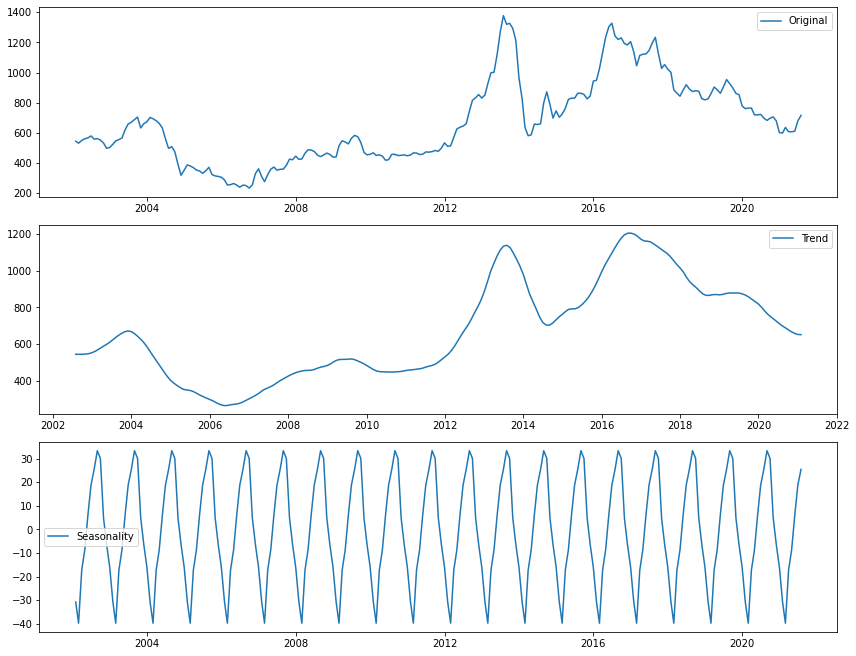

In [39]:
ts = pd.Series(list(series['cpo_pri']), index=pd.to_datetime(series['Date'],format='%Y-%m'))
series.set_index('Date')
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,12))

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.tight_layout()



plt.savefig('/content/DHC.png')

###Statistical Normality Test

* $p$ $\leq$ alpha: reject $H_0$, not normal.
* $p$ $>$ alpha: fail to reject $H_0$, normal.

In [40]:
stat, p = stats.normaltest(series.cpo_pri)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=15.641, p=0.000
Data does not look Gaussian (reject H0)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Kurtosis of normal distribution: -0.35396055370848467
Skewness of normal distribution: 0.6340534289696842


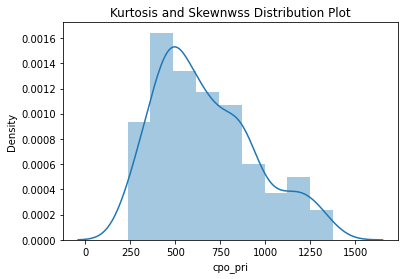

In [41]:
sns.distplot(series.cpo_pri).set(title='Kurtosis and Skewnwss Distribution Plot');
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(series.cpo_pri)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(series.cpo_pri)))

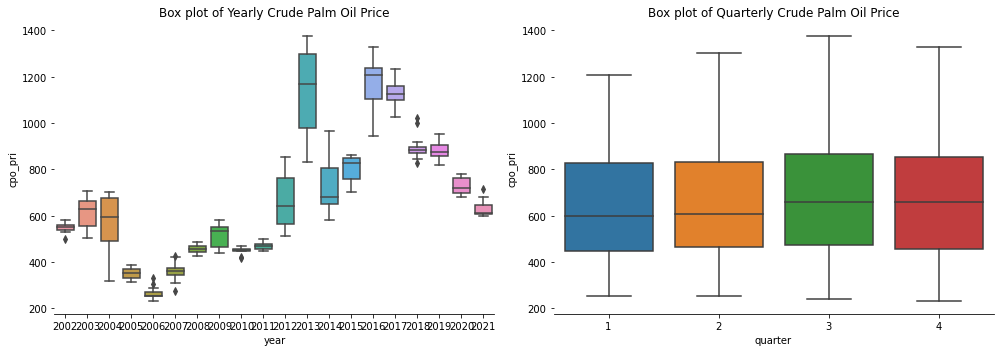

In [42]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="cpo_pri", data=series)
plt.xlabel('year')
plt.title('Box plot of Yearly Crude Palm Oil Price')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="cpo_pri", data=series)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Crude Palm Oil Price')
sns.despine(left=True)
plt.tight_layout();
plt.savefig('/content/snss.png')

###Monthly Crude Palm Oil Price Distribution

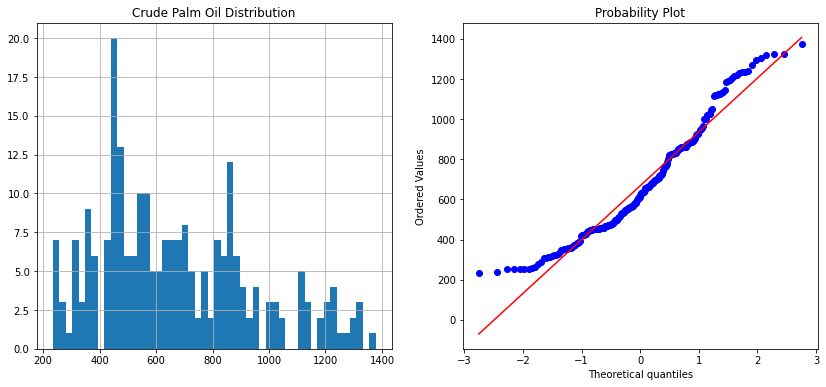

In [43]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
series.cpo_pri.hist(bins=50)
plt.title('Crude Palm Oil Distribution')
plt.subplot(1,2,2)
stats.probplot(series['cpo_pri'], plot=plt);
series.cpo_pri.describe().T
plt.savefig('/content/cpoDist.png')

###Average Crude Plam Oil Price Resampled Over Month, Quarter and Year

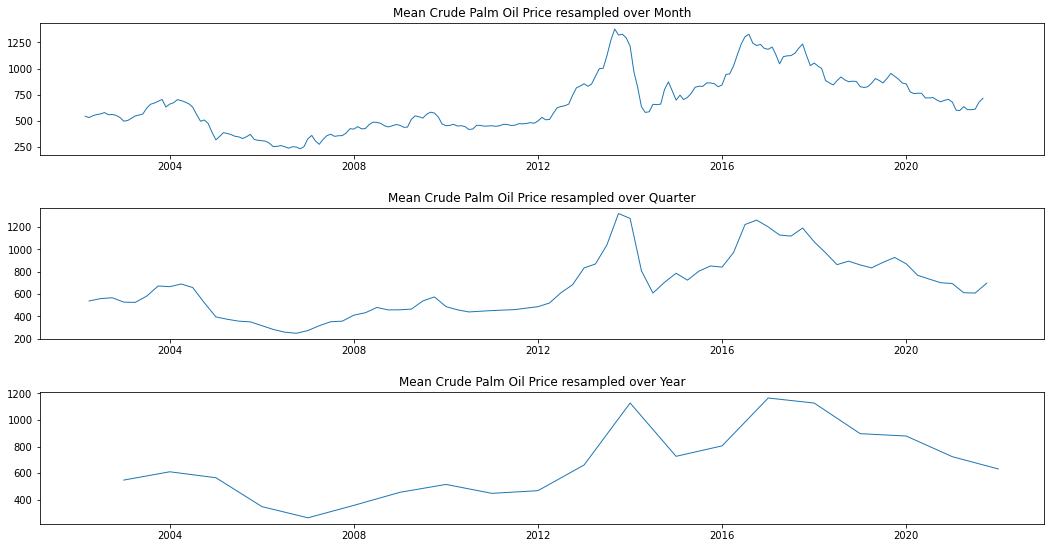

In [44]:
series1=series.loc[:,['date_time','cpo_pri']]
series1.set_index('date_time',inplace=True)

fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(series1['cpo_pri'].resample('M').mean(),linewidth=1)
ax1.set_title('Mean Crude Palm Oil Price resampled over Month')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(series1['cpo_pri'].resample('Q').mean(),linewidth=1)
ax2.set_title('Mean Crude Palm Oil Price resampled over Quarter')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(series1['cpo_pri'].resample('A').mean(),linewidth=1)
ax3.set_title('Mean Crude Palm Oil Price resampled over Year')
ax3.tick_params(axis='both', which='major')

fig.savefig('ax3_figure.png')

###Plot Mean Crude Palm Oil Price Grouped by Year, Quarter, and Month

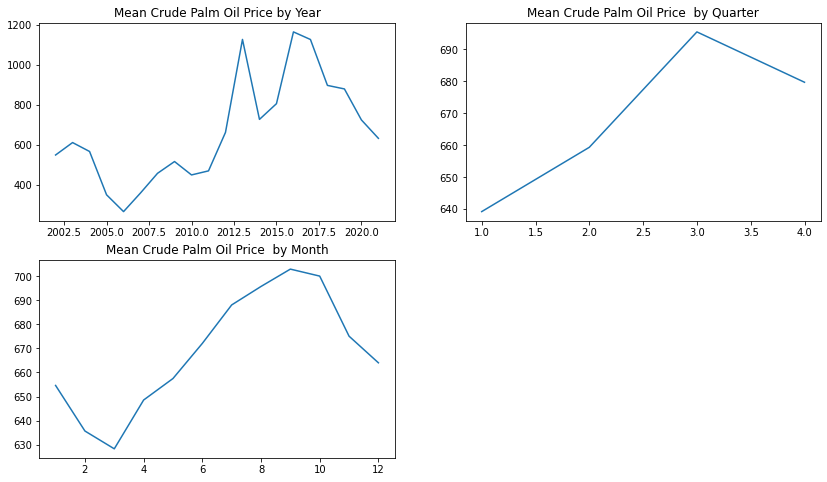

In [45]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
series.groupby('year').cpo_pri.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Crude Palm Oil Price by Year')

plt.subplot(2,2,2)
series.groupby('quarter').cpo_pri.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Crude Palm Oil Price  by Quarter')

plt.subplot(2,2,3)
series.groupby('month').cpo_pri.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Crude Palm Oil Price  by Month')

fig.savefig('CPOgymq_figure.png')

###Dickey-Fuller test


* Null Hypothesis $(H_0)$: It suggests the time series has a unit root, 
meaning it is non-stationary. It has some time-dependent structure.
* Alternate Hypothesis $(H_1)$: It suggests the time series does not have a unit root, meaning it is stationary. It does not have a time-dependent structure.
* $p$-value $>$ $0.05$: Fail to reject the null hypothesis $(H_0)$, the data has a unit root and is non-stationary.
* $p$-value $\leq$ $0.05$: Reject the null hypothesis $(H_0)$, the; data does not have a unit root and is stationary.

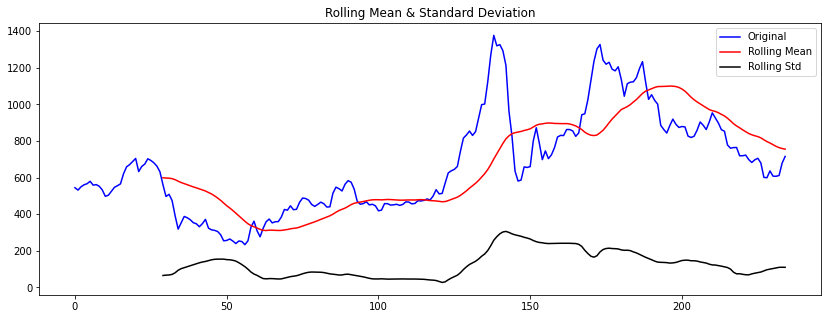

<Results of Dickey-Fuller Test>
Test Statistic                  -1.881514
p-value                          0.340807
#Lags Used                       5.000000
Number of Observations Used    229.000000
Critical Value (1%)             -3.459233
Critical Value (5%)             -2.874245
Critical Value (10%)            -2.573541
dtype: float64


<Figure size 432x288 with 0 Axes>

In [46]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(series.cpo_pri)
plt.savefig('/content/DFT.png')

In [ ]:
'''
plt.figure(figsize=(12,8))
plt.plot(series)
plt.xlabel('Time')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.title('Monthly Crude Palm Oil Price from 1996 to 2021')
plt.savefig('fig1.png', dpi=800, quality=95)
tsaplots.plot_acf(series.index, ax=None, lags=np.arange(50), use_vlines=True)
tsaplots.plot_pacf(series.index, ax=None, lags=np.arange(50), use_vlines=True)
print("ADF test results:", sm.stattools.adfuller(df.iloc[:,0], autolag='AIC'))
'''

In [47]:
series = series.drop(columns=['date_time', 'year', 'quarter', 'month'])

In [48]:
series.head()

,Date,cpo_pri
0,2002-02-01,545.0
1,2002-03-01,532.0
2,2002-04-01,550.0
3,2002-05-01,561.0
4,2002-06-01,567.0


###Compute the Percentage of outliers

In [49]:
for k, v in series.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(series)[1]
        print("Column %s outliers = %.2f%%" % (k, perc))

Column Date outliers = 0.00%
Column cpo_pri outliers = 0.00%


In [50]:
series.set_index('Date', inplace=True)

In [51]:
series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 235 entries, 2002-02-01 to 2021-08-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cpo_pri  235 non-null    float64
dtypes: float64(1)
memory usage: 3.7 KB


##Naïve Forecast
We apply the naive forecast to establish a baseline for model accuracy. First, the naive method predicts the time series by continuing the last value. Then, the last value of the last season of the forecast is used according to the seasonal pattern. 

###Split into train and test set

In [52]:
split_date = '2016-09' #'2017-06' 
series_training = series.loc[series.index <= split_date]
series_test = series.loc[series.index > split_date]
print(f"{len(series_training)} days of training data \n {len(series_test)} days of testing data ")
df_training_len = 184

176 days of training data 
 59 days of testing data 


####Plot the Data

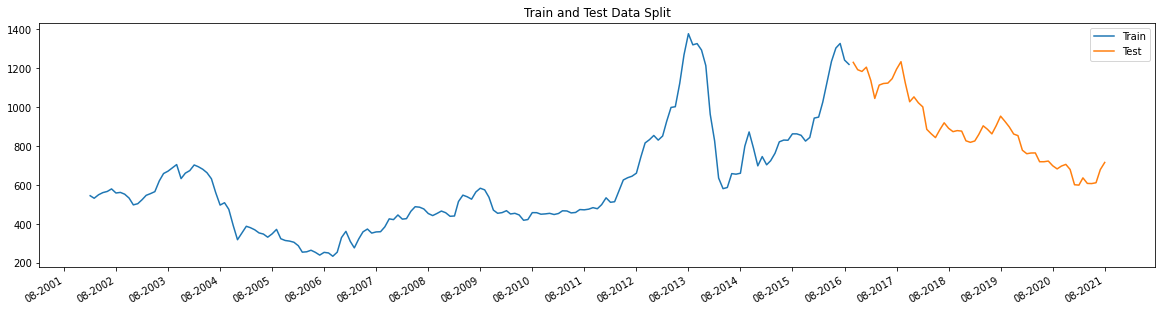

In [53]:
#Plot. data
plt.figure(figsize=(20,5))
plt.title("Train and Test Data Split")
plt.plot(series_training.index, series_training['cpo_pri'], label='Train')
plt.plot(series_test.index,series_test['cpo_pri'], label='Test')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(loc='best')
plt.show()

In [55]:
#Save the series_test to csv 
series_test.to_csv('/content/series_test.csv')

In [30]:
#series_test.head()
#Create pickle for series_test
#series_test = pd.DataFrame(series_test, columns = ['Predictions'])
#---save rnn_predictions---
#series_test_save = series_test.to_pickle('series_test.pkl')

#---load---
#series_test_read = pd.read_pickle('series_test.pkl')
#series_test.head()

In [56]:
dd = np.asarray(series_training.cpo_pri)
lastvalue = dd[len(dd)-1]
y_hat = series_test.copy()
y_hat['naive'] = lastvalue
y_hat.describe()

,cpo_pri,naive
count,59.000000,5.900000e+01
mean,884.997627,1.219610e+03
std,183.522349,4.586508e-13
min,599.500000,1.219610e+03
25%,721.340000,1.219610e+03
50%,874.170000,1.219610e+03
75%,1025.060000,1.219610e+03
max,1233.610000,1.219610e+03


###Plot Naive Forecast

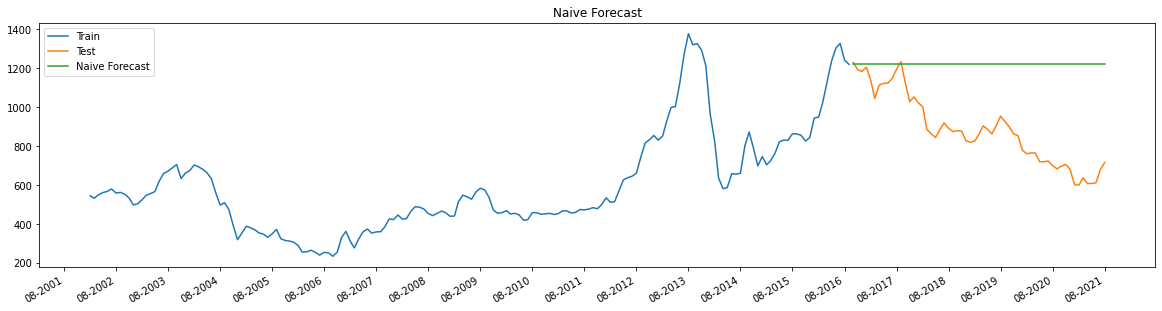

In [57]:
plt.figure(figsize=(20,5))
plt.plot(series_training.index, series_training['cpo_pri'], label='Train')
plt.plot(series_test.index,series_test['cpo_pri'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.savefig('/content/UNF.png')
plt.show()

###Evaluate the Naive Forecast

In [61]:
MAE_NF = mean_absolute_error(series_test['cpo_pri'], y_hat['naive'])
print('MAE value of Naive Forecast is:', MAE_NF.round(2))

MAPE_NF = MAPE(series_test['cpo_pri'], y_hat['naive'])
print('MAPE value Naive of Forecast is', round(MAPE_NF,2))

MSE_NF = mean_squared_error(series_test['cpo_pri'], y_hat['naive'])
print('MSE value of Naive Forecast is:', round(MSE_NF, 2))

RMSE_NF = math.sqrt(mean_squared_error(series_test['cpo_pri'], y_hat['naive']))
print('RMSE value of Naive Forecast is:',  round(RMSE_NF,2))

MAE value of Naive Forecast is: 335.44
MAPE value Naive of Forecast is 43.83
MSE value of Naive Forecast is: 145075.04
RMSE value of Naive Forecast is: 380.89


In [62]:
NF =  y_hat['naive']

In [63]:
#Save naive forecast to csv
NF.to_csv(r'/content/NF.csv')

##ARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



ADF test results: (-1.8815144840925073, 0.340806621091559, 5, 229, {'1%': -3.4592326027153493, '5%': -2.8742454699025872, '10%': -2.5735414688888465}, 2256.7796589262834)
High p-value of ADF test (0.340806621091559) shows that we fail to reject null hypothesis. 
 Hence, the dataset is non-stationary.


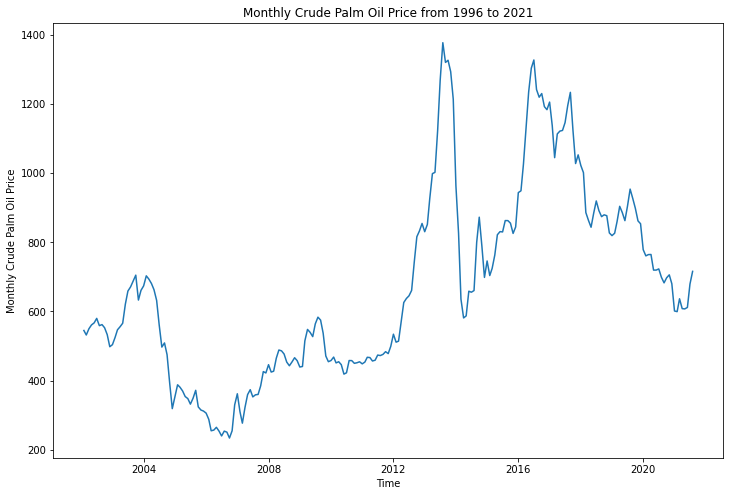

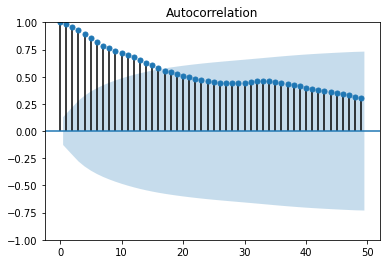

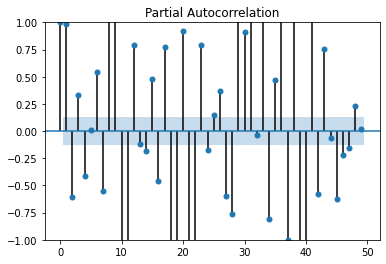

In [64]:
plt.figure(figsize=(12,8))
plt.plot(series)
plt.xlabel('Time')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.title('Monthly Crude Palm Oil Price from 1996 to 2021')
plt.savefig('fig1.png', dpi=800, quality=95)
tsaplots.plot_acf(series, ax=None, lags=np.arange(50), use_vlines=True)
tsaplots.plot_pacf(series, ax=None, lags=np.arange(50), use_vlines=True)
print("ADF test results:", sm.stattools.adfuller(series.iloc[:,0], autolag='AIC'))
print('High p-value of ADF test ({}) shows that we fail to reject null hypothesis. \n Hence, the dataset is non-stationary.'.format(sm.stattools.adfuller(series.iloc[:,0], autolag='AIC')[1]))

The ACF and PACF graphs show a significant correlation between lags, so the data is not stationary. One method removes the trend by moving the average and making it stationary for classical analysis. Manual decomposition of trend and seasonality: Use the smoothing method of moving average to remove the trend.

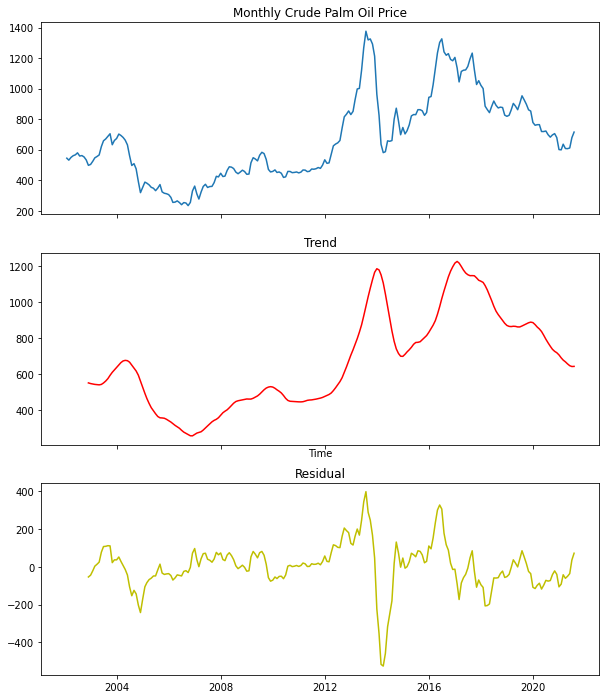

In [66]:
trendcomp = (series.rolling(10).mean()).rolling(2).mean()
res = (series - trendcomp).dropna()
noise = series.iloc[:,0] - trendcomp.iloc[:,0] 
series['trendcomp'] = trendcomp.values
series['noise'] = noise.values
fig = plt.figure(1, figsize=[10,12])
#fig.suptitle('Monthly Crude Palm Oil Price')
fig1, fig2, fig4 = fig.subplots(nrows=3, ncols=1, sharex=True, sharey=False)
fig1.set_title('Monthly Crude Palm Oil Price')
fig2.set_title('Trend')
fig4.set_title('Residual')
fig2.set_xlabel('Time')
fig1.plot(series.loc[:,'cpo_pri'])
fig2.plot(series.loc[:,'trendcomp'], 'r')
fig4.plot(series.loc[:,'noise'], 'y')
fig.show()

In [ ]:
tsaplots.plot_pacf(noise.dropna(), ax=None, lags=np.arange(50), use_vlines=True)
tsaplots.plot_acf(noise.dropna(), ax=None, lags=np.arange(50), use_vlines=True)
#ADF test on residual
print("ADF test results:", sm.stattools.adfuller(series.loc[:,'noise'].dropna(), regression='nc', autolag='AIC'))
print('low p-value of ADF test ({}) Show that we reject the null hypothesis. So the residuals are almost stationary.'.format(sm.stattools.adfuller(series.loc[:,'noise'].dropna(), autolag='AIC')[1]))
print('The P value of the ADF test (no constant, no trend) indicates that the data is stationary. So we can say that the data has a stationary trend.')

As we have seen, it is not easy to remove trend components through moving averages. Another way is to do differencing between data sets. Manually decompose seasonality and trend: Differencing method to see if the time series is difference stationery!

In [ ]:
diff1 = series.loc[:,'cpo_pri'].diff(1)
nn = diff1.dropna()
plt.plot(nn,'r')
plt.title('Differenced Data')
plt.xlabel('Time')
plt.ylabel('Monthly Crude Palm Oil Price')

# ADF test on difference data:
print("ADF test results:", sm.stattools.adfuller(nn, regression='nc', autolag='AIC'))
print('The low p-value of ADF test ({}) indicates that we will reject null hypothesis. \n Hence, the residual is close to stationary.'.format(sm.stattools.adfuller(nn, regression='nc', autolag='AIC')[1]))
print('Data is not getting stationary by multiple differencings. So data is trend stationary.')

###Apply grid Search Algorithm to Obtain Optimal P,D,Q

In this step, we use grid search to find the best hyperparameters (values ​​whose composition changes the behavior of the ARIMA model). Traditionally, autocorrelation functions (ACFs) and PACFs have been used to find the subjective optimal hyperparameters.

In [67]:
stepwise_fit = auto_arima(series_training['cpo_pri'] , start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True)        
  
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.64 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2257.437, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1822.632, Time=0.59 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2259.913, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1851.774, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1797.691, Time=1.68 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.06 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2227.969, Time=1.68 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1750.278, Time=2.96 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1769.690, Time=0.65 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.72 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.40 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=1751.7

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  176
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -869.452
Date:                            Mon, 03 Jan 2022   AIC                           1748.904
Time:                                    22:28:11   BIC                           1764.403
Sample:                                         0   HQIC                          1755.196
                                            - 176                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4667      0.064     23.002      0.000       1.342       1.592
ar.L2         -0.5109      0.062     -8.234      0.000      -0.632      -0.389
ar.S.L12      -0.6942      0.057    -12.183      0.000      -0.806      -0.582
ar.S.L24      -0.4217      0.085     -4.964      0.000      -0.588      -0.255
sigma2      2197.5405    193.309     11.368      0.000    1818.662    2576.419
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                31.34
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               4.24   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Inference**

The minimum AIC value was obtained by parameters with $p=2, d=0, q=0$.

###Develop the ARIMA/Sarima Model

In [68]:
arima_model = SARIMAX(series_training['cpo_pri'], 
                order = (2, 0, 0), 
                seasonal_order =(2, 1, 0, 12))
  
arima_result = arima_model.fit()
arima_result.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            cpo_pri   No. Observations:                  176
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -869.452
Date:                            Mon, 03 Jan 2022   AIC                           1748.904
Time:                                    22:36:20   BIC                           1764.403
Sample:                                02-01-2002   HQIC                          1755.196
                                     - 09-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4667      0.064     23.002      0.000       1.342       1.592
ar.L2         -0.5109      0.062     -8.234      0.000      -0.632      -0.389
ar.S.L12      -0.6942      0.057    -12.183      0.000      -0.806      -0.582
ar.S.L24      -0.4217      0.085     -4.964      0.000      -0.588      -0.255
sigma2      2197.5405    193.309     11.368      0.000    1818.662    2576.419
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                31.34
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               4.24   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
arima_pred = arima_result.predict(start = len(series_training), end = len(series)-1, typ="levels").rename("ARIMA_Predictions")
arima_pred

2016-10-01    1213.523285
2016-11-01    1147.244479
2016-12-01    1078.497630
2017-01-01    1002.874535
2017-02-01     923.396826
2017-03-01     862.345210
2017-04-01     873.386587
2017-05-01     915.662351
2017-06-01     962.382005
2017-07-01     961.991651
2017-08-01     941.319126
2017-09-01     988.301098
2017-10-01    1010.753350
2017-11-01     943.005358
2017-12-01     885.539223
2018-01-01     906.336190
2018-02-01     862.773776
2018-03-01     871.274225
2018-04-01     917.404964
2018-05-01     981.066448
2018-06-01    1016.103178
2018-07-01    1020.387899
2018-08-01    1003.133439
2018-09-01    1010.082208
2018-10-01    1010.966595
2018-11-01     958.614859
2018-12-01     929.249971
2019-01-01     956.018365
2019-02-01     922.435346
2019-03-01     940.155874
2019-04-01    1001.149982
2019-05-01    1075.130089
2019-06-01    1127.137296
2019-07-01    1137.856891
2019-08-01    1090.494063
2019-09-01    1095.718908
2019-10-01    1099.210302
2019-11-01    1036.495861
2019-12-01  

In [ ]:
#Create picle for ARIMA_predictions
#arima_pred = pd.DataFrame(arima_pred, columns = ['arima_pred'])
#---save rnn_predictions---
#arimapred_save = arima_pred.to_pickle('arima_pred.pkl')

#---load---
#arimapred_read = pd.read_pickle('arima_pred.pkl')
#arima_pred.head()

In [70]:
#Save the ARIMA predictions tocsv
arima_pred.to_csv(r'/content/arima_pred.csv')

###Plot the ARIMA Forecasted Values

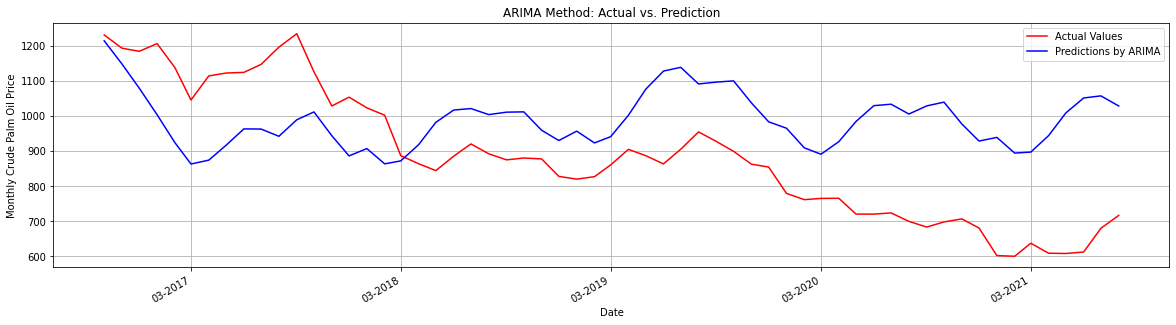

<Figure size 432x288 with 0 Axes>

In [72]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(series_test.index, series_test['cpo_pri'], color = 'red',  label = 'Test')
plt.plot(series_test.index,   arima_pred, color = 'blue',label = 'ARIMA Prediction')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(['Actual Values', 'Predictions by ARIMA', 'ARIMA Prediction'],loc='best')
plt.title('ARIMA Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()
plt.savefig('/content/ARIMA_UZI.png')

###Evaluate the ARIMA model

In [73]:
MAE_arima = mean_absolute_error(series_test['cpo_pri'], arima_pred)
print('MAE value of ARIMA is:', MAE_arima.round(2))

MAPE_arima = MAPE(series_test['cpo_pri'], arima_pred)
print('MAPE value ARIMA is', round(MAPE_arima,2))

MSE_arima = mean_squared_error(series_test['cpo_pri'], arima_pred)
print('MSE value of ARIMA is:', round(MSE_arima, 2))

RMSE_arima = math.sqrt(mean_squared_error(series_test['cpo_pri'], arima_pred))
print('RMSE value of ARIMA is:',  round(RMSE_arima,2))

MAE value of ARIMA is: 192.44
MAPE value ARIMA is 24.21
MSE value of ARIMA is: 46568.73
RMSE value of ARIMA is: 215.8


##Application of Deep Learning to the Monthly Crude Palm Oil Price Predictions

In [58]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = pd.DataFrame({"cpo_pri":scaler.fit_transform(np.array(series['cpo_pri']).reshape(len(series),1)).reshape(len(series),)}, index = series.index)

###Split Data into Train & Test Sets

In [59]:
trainfrac = 0.75
df_train, df_test = train_test_split(df, train_size=trainfrac, shuffle=False, stratify=None, random_state = 42)

###Prepare Data

In [60]:
# This function produces input output
def input_output_generator(z,n):
    x_train = []
    y_train = []
    x_test = []
    y_test = z[math.floor(trainfrac*len(z)):]
    z_train = z[:math.floor(trainfrac*len(z))]
    for i in range(len(z_train)-n):
        x_train.append(z[i:i+n])
        y_train.append(z[i+n])
    for i in range(len(y_test)):
        x_test.append(z[len(z_train)-n+i:len(z_train)+i])
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [61]:
def Model_Build(Type,nodes,X_train, optimizer, learning_rate):
# This function creates a model. The type is the type of deep learning model. MLPs, LSTMs, ... 
 # Nodes define a sequence of nodes at different network layers. It must be a list. 
 # Compile the model using the optimizer and learning rate
    model = Sequential()
    if Type == 'MLP':
        model.add(Dense(nodes[0], activation='relu', input_shape=(X_train.shape[1],),
                        kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        for i in range(len(nodes)-1):
            model.add(Dense(nodes[i+1], activation='relu', kernel_initializer='random_uniform',
                            bias_initializer='RandomNormal'))

    if Type == 'LSTM':
        model.add(LSTM(nodes, activation='relu', kernel_initializer='RandomNormal',
                       input_shape=(X_train[1,:].shape)))
        model.add(Dense(1))
##
    if Type == 'SimpleRNN':
        if type(nodes) == int:
            model.add(SimpleRNN(nodes, input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'tanh',
                               kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        else:
            model.add(SimpleRNN(nodes[0], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'tanh',
                                return_sequences=True, kernel_initializer='random_uniform', 
                                bias_initializer='RandomNormal'))
            for i in range(len(nodes)-1):
                retseq = True
                if (i+1) == (len(nodes)-1):
                    retseq = False
                model.add(SimpleRNN(nodes[i+1], activation='tanh', return_sequences=retseq, 
                                    kernel_initializer='random_uniform',bias_initializer='RandomNormal'))
        model.add(Dense(1, activation='relu', kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
 ##
    if optimizer == 'SGD':
        sgd = optimizers.SGD(lr=learning_rate, momentum=0)
        model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy', 'mse'])
    if optimizer == 'RMSprop':
        rmsprop = optimizers.RMSprop(lr=learning_rate, rho=0.9)
        model.compile(loss='mean_squared_error', optimizer=rmsprop, metrics=['accuracy', 'mse'])
    if optimizer == 'Adagrad':
        adagrad = optimizers.Adagrad(lr=learning_rate)
        model.compile(loss='mean_squared_error', optimizer=adagrad, metrics=['accuracy', 'mse'])
    if optimizer == 'Adadelta':
        adadelta = optimizers.Adadelta(lr=learning_rate, rho=0.95)
        model.compile(loss='mean_squared_error', optimizer=adadelta, metrics=['accuracy', 'mse'])
    if optimizer == 'Adam':
        adam = optimizers.Adam(learning_rate)
        model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy', 'mse'])
    return model

def Tune_epoch(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this funciton tunes number of epochs of the model.
    e = [0 for i in range(len(epochs))]
    ii = 0
    for i in epochs:
        model = Model_Build(Type,nodes,X_train, optimizer, learning_rate)
        history_lstm = model.fit(X_train, Y_train, validation_split=val_split, epochs=i, batch_size=batch_size, verbose=0, shuffle=False)
        e[ii] = history_lstm.history['val_loss'][-1]
        ii += 1
    return e

def Tune_nodes(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes number of nodes.
    e = {}
    if np.size(np.shape(nodes)) == 1:
        for i in nodes:
            model = Model_Build(Type, i, X_train, optimizer, learning_rate)
            history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
            e[i] = history.history['val_loss'][-1]
    else:
        for i in range(np.shape(nodes)[0]):
            model = Model_Build(Type, nodes[i], X_train, optimizer, learning_rate)
            history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
            e[i] = history.history['val_loss'][-1]
    return e

def Tune_optimizer(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes the optimizer and the learning rate.
    e = {}
    for i in range(len(optimizer)):
        for j in range(len(learning_rate)):
            model = Model_Build(Type, nodes, X_train, optimizer[i], learning_rate[j])
            history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
            e[optimizer[i]+', rate='+str(learning_rate[j])] = history.history['val_loss'][-1]
    return e

def Tune_batch(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes the batch size.
    e = {}
    for i in batch_size:
        model = Model_Build(Type, nodes, X_train, optimizer, learning_rate)
        history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=i, verbose=0, shuffle=False)
        e[i] = history.history['val_loss'][-1]
    return e

##MLP

In [62]:
lag_mlp = 5 # lag is the number of prior steps
X_train_mlp, Y_train_mlp, X_test_mlp, Y_test_mlp = input_output_generator(df['cpo_pri'].tolist(), lag_mlp)

In [63]:
#Tune optimizer. To give us a good starting point.
opt = ['Adam', 'Adagrad']
lr = [0.001, 0.01]
nodes = [64,32,8,1]
e = Tune_optimizer('MLP', X_train_mlp, Y_train_mlp, nodes, validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



{'Adagrad, rate=0.001': 0.4286513328552246,
 'Adagrad, rate=0.01': 0.21024444699287415,
 'Adam, rate=0.001': 0.4286513328552246,
 'Adam, rate=0.01': 0.4286513328552246}

In [64]:
#Tune the number of layers and nodes in MLP 
#Here are some suggestions for comparison

nodes = [[200,100,50,1],[64,32,16,1],[128,64,16,1]]
e = Tune_nodes('MLP', X_train_mlp, Y_train_mlp, nodes, validation_split, 50, 10, optimizer, learning_rate)
e

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



{0: 0.20194949209690094, 1: 0.4286513328552246, 2: 0.20400366187095642}

In [65]:
nodes_mlp = [200, 100, 50, 1]

In [66]:
#tune batch size
batch = [5, 10, 30]
e = Tune_batch('MLP', X_train_mlp, Y_train_mlp, nodes_mlp, validation_split, 50, batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [67]:
#Set the hyperparameters required to build the model
batch_size = 10
nodes_mlp = [100, 50, 20, 1]
optimizer = 'Adam'
learning_rate = 0.001

Epoch 1/200
13/13 [==============================] - 1s 17ms/step - loss: 0.0556 - accuracy: 0.0078 - mse: 0.0556 - val_loss: 0.3989 - val_accuracy: 0.0000e+00 - val_mse: 0.3989
Epoch 2/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0460 - accuracy: 0.0078 - mse: 0.0460 - val_loss: 0.3566 - val_accuracy: 0.0000e+00 - val_mse: 0.3566
Epoch 3/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0318 - accuracy: 0.0078 - mse: 0.0318 - val_loss: 0.2718 - val_accuracy: 0.0000e+00 - val_mse: 0.2718
Epoch 4/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0153 - accuracy: 0.0078 - mse: 0.0153 - val_loss: 0.1519 - val_accuracy: 0.0000e+00 - val_mse: 0.1519
Epoch 5/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0112 - accuracy: 0.0078 - mse: 0.0112 - val_loss: 0.1017 - val_accuracy: 0.0000e+00 - val_mse: 0.1017
Epoch 6/200
13/13 [==============================] - 0s 6ms/step - loss: 0.0109 - accuracy: 0.0078 - mse: 0.0109 -

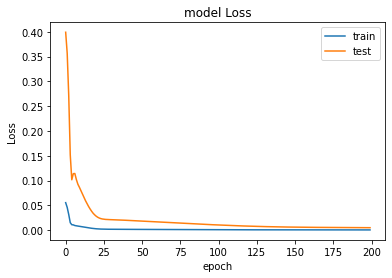

In [68]:
model_mlp = Model_Build('MLP', nodes_mlp, X_train_mlp, optimizer, learning_rate)
history_mlp = model_mlp.fit(X_train_mlp, Y_train_mlp, validation_split=validation_split, epochs=200,
                            batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Epoch 1/50
13/13 [==============================] - 1s 18ms/step - loss: 0.0428 - accuracy: 0.0078 - mse: 0.0428 - val_loss: 0.3573 - val_accuracy: 0.0000e+00 - val_mse: 0.3573
Epoch 2/50
13/13 [==============================] - 0s 6ms/step - loss: 0.0349 - accuracy: 0.0078 - mse: 0.0349 - val_loss: 0.3252 - val_accuracy: 0.0000e+00 - val_mse: 0.3252
Epoch 3/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0264 - accuracy: 0.0078 - mse: 0.0264 - val_loss: 0.2752 - val_accuracy: 0.0000e+00 - val_mse: 0.2752
Epoch 4/50
13/13 [==============================] - 0s 6ms/step - loss: 0.0170 - accuracy: 0.0078 - mse: 0.0170 - val_loss: 0.1994 - val_accuracy: 0.0000e+00 - val_mse: 0.1994
Epoch 5/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0120 - accuracy: 0.0078 - mse: 0.0120 - val_loss: 0.1394 - val_accuracy: 0.0000e+00 - val_mse: 0.1394
Epoch 6/50
13/13 [==============================] - 0s 5ms/step - loss: 0.0120 - accuracy: 0.0078 - mse: 0.0120 - val_l

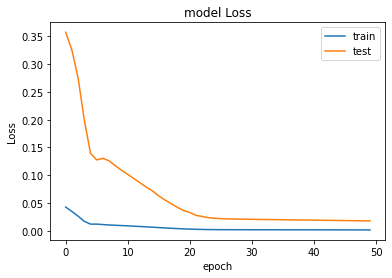

In [70]:
# 50 epochs are enough for training the model.
model_mlp = Model_Build('MLP', nodes_mlp, X_train_mlp, optimizer, learning_rate)
history_mlp = model_mlp.fit(X_train_mlp, Y_train_mlp, epochs=50,validation_split=validation_split,
                            batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [71]:
#Build, execute, and train the model:
trainprediction_mlp = model_mlp.predict(X_train_mlp)
testprediction_mlp = model_mlp.predict(X_test_mlp)
trainprediction_mlp = pd.DataFrame(index=df.index[lag_mlp:len(df)-len(X_test_mlp)], data=trainprediction_mlp)
testprediction_mlp = pd.DataFrame(index=df.index[len(df)-len(X_test_mlp):], data=testprediction_mlp)

###Invert Transform Data

In [72]:
trainPredictMLP = scaler.inverse_transform(trainprediction_mlp)
trainYMLP = scaler.inverse_transform([Y_train_mlp])
testPredictMLP = scaler.inverse_transform(testprediction_mlp)
testYMLP = scaler.inverse_transform([Y_test_mlp])

###Generate Dates for Index

In [73]:
dates = pd.date_range(start='2003-01', freq='MS', periods=trainYMLP.shape[1])

###Create Dataframes for MLP Actual Values and Predicted Values of Train Data

In [74]:
trainActualMLP = pd.DataFrame({'cpo_pri': trainYMLP[0]})
trainActualMLP.index = dates

trainPredictdfMLP = pd.DataFrame({'cpo_pri': trainPredictMLP[:,0]})
trainPredictdfMLP.index = dates

Plot the predicted values

* Actual values - red
* Predicted values - blue


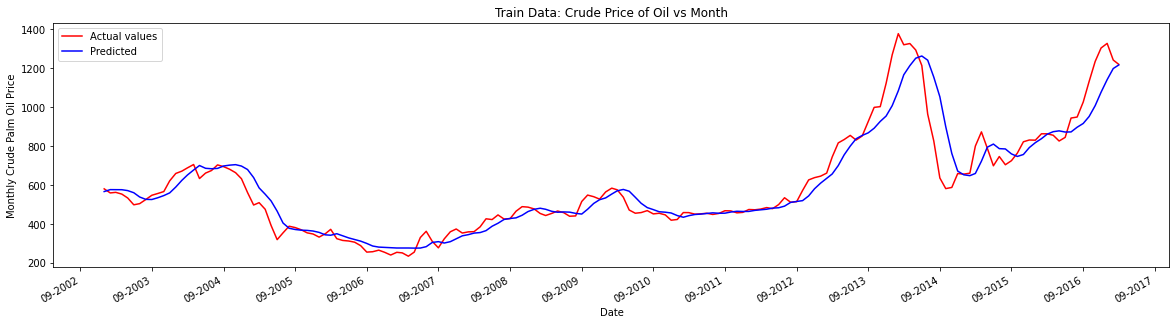

In [75]:
plt.figure(figsize=(20,5))
plt.plot(trainActualMLP, color='red', label='Actual values')
plt.plot(trainPredictdfMLP, color='blue', label='Predicted')
plt.title('Train Data: Crude Price of Oil vs Month')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.xlabel('Date')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.legend(loc='best')

###Create Dataframes for MLP Actual Values and Predicted Values of Test Data

In [76]:
#Create a dataframe for MLP_predictions
mlp_predictions = pd.DataFrame(testPredictMLP, columns = ['mlp_pred'])
mlp_predictions.head()

#Create picle for MLP_predictions
#mlp_predictions = pd.DataFrame(testPredictMLP, columns = ['mlp_pred'])
#---save rnn_predictions---
#mlppred_save = df.to_pickle('mlp_pred.pkl')

#---load---
#mlpmpred_read = pd.read_pickle('mlp_predictions.pkl')
#mlp_predictions.head()

,mlp_pred
0,1216.551025
1,1210.315918
2,1191.158813
3,1172.265747
4,1168.834961


In [77]:
#Reshape testYMLP
testYMLP = testYMLP.reshape(-1,1)

In [78]:
#Create a dataframe for testYMLP 
testYMLP  = pd.DataFrame(testYMLP, columns = ['Actual'])

###Plot the MLP Forecasted Values

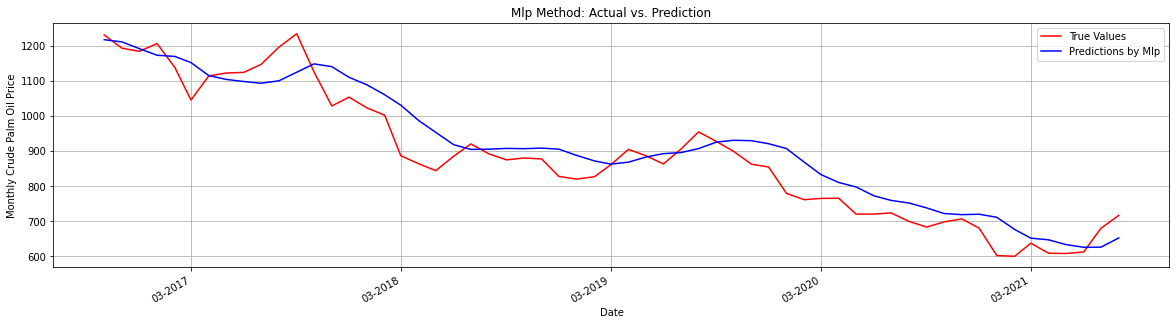

<Figure size 432x288 with 0 Axes>

In [79]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(df_test.index, testYMLP, color = 'red',  label = 'Test')
plt.plot(df_test.index,   mlp_predictions, color = 'blue',label = 'MLP Prediction')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(['True Values', 'Predictions by Mlp', 'MLP Prediction'],loc='best')
plt.title('Mlp Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()
plt.savefig('/content/MLP_UZI.png')

###Evaluate the MLP model

In [80]:
MAE_mlp = mean_absolute_error(testYMLP, mlp_predictions)
print('MAE value of MLP is:', MAE_mlp.round(2))

MAPE_mlp = MAPE(testYMLP, mlp_predictions)
print('MAPE value MLP is', round(MAPE_mlp,2))

MSE_mlp = mean_squared_error(testYMLP, mlp_predictions)
print('MSE value of MLP is:', round(MSE_mlp, 2))

RMSE_mlp = math.sqrt(mean_squared_error(testYMLP, mlp_predictions))
print('RMSE value of MLP is:',  round(RMSE_mlp,2))

MAE value of MLP is: 49.73
MAPE value MLP is 5.92
MSE value of MLP is: 3757.48
RMSE value of MLP is: 61.3


In [81]:
#Save mlp_predictions to csv
mlp_predictions.to_csv(r'/content/mlp_predictions.csv')

##Long Short Term Memory (LSTM)

In [91]:
def input_output_generator_LSTM(z,n):
    #generate input output sets for LSTM models
    x_train = []
    y_train = []
    x_test = []
    y_test = z[math.floor(trainfrac*len(z)):]
    z_train = z[:math.floor(trainfrac*len(z))]
    for i in range(len(z_train)-n):
        x_train.append(z[i:i+n])
        y_train.append(z[i+n])
    for i in range(len(y_test)):
        x_test.append(z[len(z_train)-n+i:len(z_train)+i])
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    x_train_lstm = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
    x_test_lstm = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))
    return x_train_lstm, np.array(y_train), x_test_lstm, np.array(y_test)

In [92]:
lag_lstm = 3
X_train_lstm, Y_train_lstm, X_test_lstm, Y_test_lstm = input_output_generator_LSTM(df['cpo_pri'].tolist(), lag_lstm)

In [93]:
#Tune optimizer. To give us a good starting point.
opt = ['SGD', 'Adam']
lr = [0.001, 0.01, 0.1]
e = Tune_optimizer('LSTM', X_train_lstm, Y_train_lstm, 50, validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



{'Adam, rate=0.001': 0.016575844958424568,
 'Adam, rate=0.01': 0.004583899863064289,
 'Adam, rate=0.1': 0.2397167831659317,
 'SGD, rate=0.001': 0.2055409997701645,
 'SGD, rate=0.01': 0.19252771139144897,
 'SGD, rate=0.1': 0.04785145819187164}

In [94]:
#Optimize the number of nodes in the LSTM layer
nodes = [1, 10, 50, 100, 200, 500]
e = Tune_nodes('LSTM', X_train_lstm, Y_train_lstm, nodes, validation_split, 50, 10, optimizer, learning_rate)
nodes = int(min(e, key=e.get))

In [95]:
#Tune batch size
batch = [1, 10, 20, 30]
e = Tune_batch('LSTM', X_train_lstm, Y_train_lstm, nodes, validation_split, 50,
               batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

In [96]:
nodes = 500    
batch_size= 20  
learning_rate = 0.01
optimizer = 'Adam'
model_lstm = Model_Build('LSTM', nodes, X_train_lstm, optimizer, learning_rate)
model_lstm.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 500)               1004000   
                                                                 
 dense_85 (Dense)            (None, 1)                 501       
                                                                 
Total params: 1,004,501
Trainable params: 1,004,501
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
7/7 [==============================] - 2s 83ms/step - loss: 0.0265 - accuracy: 0.0078 - mse: 0.0265 - val_loss: 0.0309 - val_accuracy: 0.0227 - val_mse: 0.0309
Epoch 2/100
7/7 [==============================] - 0s 37ms/step - loss: 0.0118 - accuracy: 0.0078 - mse: 0.0118 - val_loss: 0.0644 - val_accuracy: 0.0227 - val_mse: 0.0644
Epoch 3/100
7/7 [==============================] - 0s 36ms/step - loss: 0.0034 - accuracy: 0.0078 - mse: 0.0034 - val_loss: 0.0166 - val_accuracy: 0.0227 - val_mse: 0.0166
Epoch 4/100
7/7 [==============================] - 0s 37ms/step - loss: 0.0035 - accuracy: 0.0078 - mse: 0.0035 - val_loss: 0.0194 - val_accuracy: 0.0227 - val_mse: 0.0194
Epoch 5/100
7/7 [==============================] - 0s 35ms/step - loss: 0.0020 - accuracy: 0.0078 - mse: 0.0020 - val_loss: 0.0368 - val_accuracy: 0.0227 - val_mse: 0.0368
Epoch 6/100
7/7 [==============================] - 0s 37ms/step - loss: 0.0021 - accuracy: 0.0078 - mse: 0.0021 - val_loss: 0.0431 - val_acc

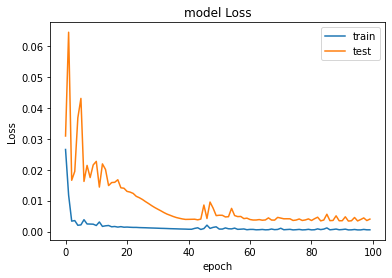

In [97]:
history_lstm = model_lstm.fit(X_train_lstm, Y_train_lstm, validation_split=validation_split, 
                              epochs=100, batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [98]:
trainprediction_lstm = model_lstm.predict(X_train_lstm)
testprediction_lstm = model_lstm.predict(X_test_lstm)
trainprediction_lstm = pd.DataFrame(index=df.index[lag_lstm:len(df)-len(X_test_lstm)], data=trainprediction_lstm)
testprediction_lstm = pd.DataFrame(index=df.index[len(df)-len(X_test_lstm):], data=testprediction_lstm)

###Invert Transform Data

In [99]:
trainPredictLSTM = scaler.inverse_transform(trainprediction_lstm)
trainYLSTM = scaler.inverse_transform([Y_train_lstm])
testPredictLSTM = scaler.inverse_transform(testprediction_lstm)
testYLSTM = scaler.inverse_transform([Y_test_lstm])

###Generate Dates for Index

In [100]:
dates = pd.date_range(start='2003-01', freq='MS', periods=trainYLSTM.shape[1])

###Create Dataframes for LSTM Actual Values and Predicted Values of Train Data

In [101]:
trainActualLSTM = pd.DataFrame({'cpo_pri': trainYLSTM[0]})
trainActualLSTM.index = dates

trainPredictdfLSTM = pd.DataFrame({'cpo_pri': trainPredictLSTM[:,0]})
trainPredictdfLSTM.index = dates

Plot the predicted values

* Actual values - red
* Predicted values - blue

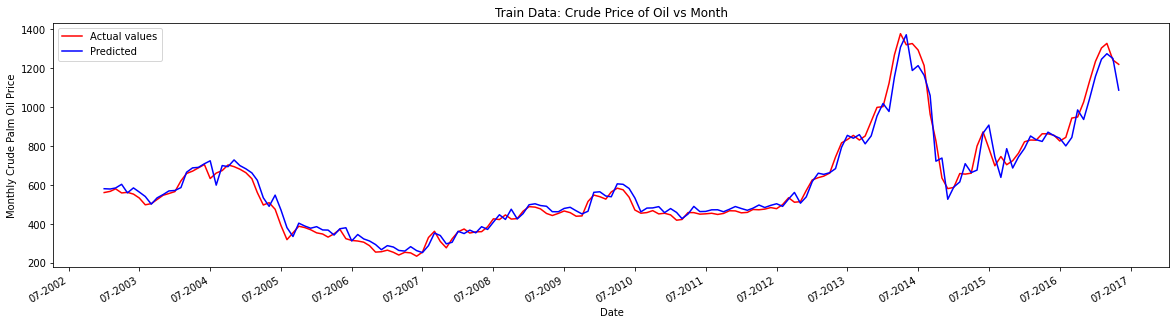

In [102]:
plt.figure(figsize=(20,5))
plt.plot(trainActualLSTM, color='red', label='Actual values')
plt.plot(trainPredictdfLSTM, color='blue', label='Predicted')
plt.title('Train Data: Crude Price of Oil vs Month')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.xlabel('Date')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.legend(loc='best')

###Create Dataframes for LSTM Actual Values and Predicted Values of Test Data

In [103]:
#Create a dataframe for MLP_predictions
lstm_predictions = pd.DataFrame(testPredictLSTM, columns = ['lstm_pred'])

#Create picle for LSTM_predictions
#lstm_predictions = pd.DataFrame(testPredictLSTM, columns = ['lstm_pred'])
#---save rnn_predictions---
#lstmpred_save = df.to_pickle('lstm_pred.pkl')

#---load---
#lstmpred_read = pd.read_pickle('lstm_predictions.pkl')
#lstm_predictions.head()

In [104]:
#Reshape testYLSTM
testYLSTM = testYLSTM.reshape(-1,1)

In [105]:
#Create a dataframe for testYLSTM
testYLSTM  = pd.DataFrame(testYLSTM, columns = ['Actual'])

###Plot the LSTM Forecasted Values

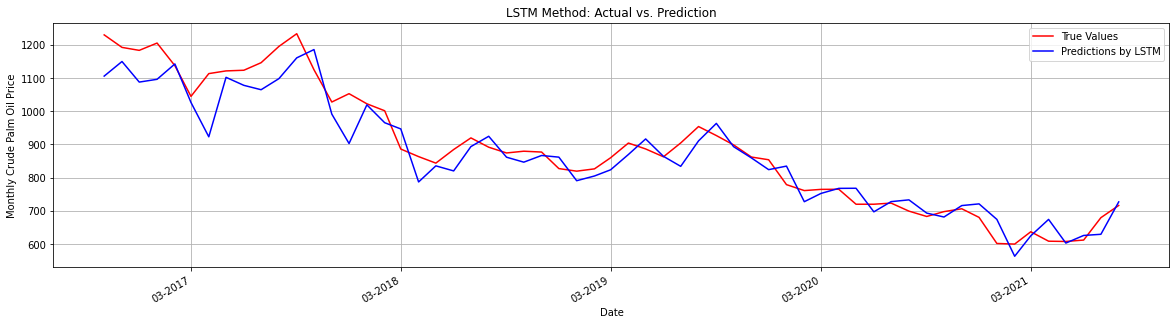

<Figure size 432x288 with 0 Axes>

In [106]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(df_test.index, testYLSTM, color = 'red',  label = 'Test')
plt.plot(df_test.index, lstm_predictions, color = 'blue',label = 'LSTM Prediction')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(['True Values', 'Predictions by LSTM', 'LSTM Prediction'],loc='best')
plt.title('LSTM Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()
plt.savefig('/content/LSTM_UZI.png')

### Evaluate the LSTM model

In [107]:
MAE_lstm = mean_absolute_error(testYLSTM, lstm_predictions)
print('MAE value of LSTM is:', MAE_lstm.round(2))

MAPE_lstm = MAPE(testYLSTM, lstm_predictions)
print('MAPE value of LSTM is', round(MAPE_lstm,2))

MSE_lstm = mean_squared_error(testYLSTM, lstm_predictions)
print('MSE value of LSTM is:', round(MSE_lstm, 2))

RMSE_lstm = math.sqrt(mean_squared_error(testYLSTM, lstm_predictions))
print('RMSE value of LSTM is: RMSE', round(RMSE_lstm, 2))

MAE value of LSTM is: 41.46
MAPE value of LSTM is 4.52
MSE value of LSTM is: 3119.17
RMSE value of LSTM is: RMSE 55.85


In [108]:
#Save LSTM prediction to csv
lstm_predictions.to_csv(r'/content/lstm_predictions.csv')

##RNN
 

In [109]:
lag_rnn = 5
X_train_rnn, Y_train_rnn, X_test_rnn, Y_test_rnn = input_output_generator_LSTM(df['cpo_pri'].tolist(), lag_rnn)

In [110]:
#Tune optimizer
opt = ['Adam', 'Adagrad']
lr = [0.001, 0.1]
e = Tune_optimizer('SimpleRNN', X_train_rnn, Y_train_rnn, 128, validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



{'Adagrad, rate=0.001': 0.18185727298259735,
 'Adagrad, rate=0.1': 0.0069535705260932446,
 'Adam, rate=0.001': 0.014492151327431202,
 'Adam, rate=0.1': 0.4286513328552246}

In [111]:
#Tune number of nodes in RNN layer
nodes = [[128, 64], [64, 64], [64, 32]]
e = Tune_nodes('SimpleRNN', X_train_rnn, Y_train_rnn, nodes, validation_split, 50, 10, optimizer, learning_rate)
e

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



{0: 0.01890571229159832, 1: 0.020118961110711098, 2: 0.4286513328552246}

In [112]:
nodes = [128, 64]

In [113]:
#tune batch size
batch = [10, 30]
e = Tune_batch('SimpleRNN', X_train_rnn, Y_train_rnn, nodes, validation_split, 50, batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [114]:
nodes = 400
batch_size = 50
learning_rate = 0.0005
optimizer = 'Adam'
model_rnn = Model_Build('SimpleRNN', nodes, X_train_rnn, optimizer, learning_rate)
model_rnn.summary()

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_14 (SimpleRNN)   (None, 400)               160800    
                                                                 
 dense_95 (Dense)            (None, 1)                 401       
                                                                 
Total params: 161,201
Trainable params: 161,201
Non-trainable params: 0
_________________________________________________________________


Epoch 1/300
3/3 [==============================] - 1s 152ms/step - loss: 0.0341 - accuracy: 0.0078 - mse: 0.0341 - val_loss: 0.1080 - val_accuracy: 0.0000e+00 - val_mse: 0.1080
Epoch 2/300
3/3 [==============================] - 0s 26ms/step - loss: 0.0239 - accuracy: 0.0078 - mse: 0.0239 - val_loss: 0.2159 - val_accuracy: 0.0000e+00 - val_mse: 0.2159
Epoch 3/300
3/3 [==============================] - 0s 25ms/step - loss: 0.0158 - accuracy: 0.0078 - mse: 0.0158 - val_loss: 0.1858 - val_accuracy: 0.0000e+00 - val_mse: 0.1858
Epoch 4/300
3/3 [==============================] - 0s 54ms/step - loss: 0.0106 - accuracy: 0.0078 - mse: 0.0106 - val_loss: 0.1086 - val_accuracy: 0.0000e+00 - val_mse: 0.1086
Epoch 5/300
3/3 [==============================] - 0s 38ms/step - loss: 0.0136 - accuracy: 0.0078 - mse: 0.0136 - val_loss: 0.0944 - val_accuracy: 0.0000e+00 - val_mse: 0.0944
Epoch 6/300
3/3 [==============================] - 0s 29ms/step - loss: 0.0116 - accuracy: 0.0078 - mse: 0.0116 - val_l

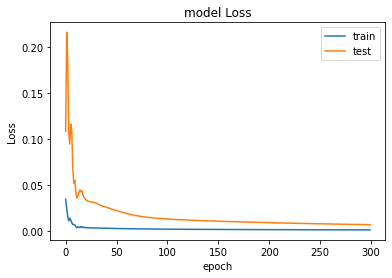

In [115]:
history_rnn = model_rnn.fit(X_train_rnn, Y_train_rnn, validation_split=validation_split, epochs=300,
                            batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [130]:
trainprediction_rnn = model_rnn.predict(X_train_rnn)
testprediction_rnn = model_rnn.predict(X_test_rnn)
trainprediction_rnn = pd.DataFrame(index=df.index[lag_rnn:len(df)-len(X_test_rnn)], data=trainprediction_rnn)
testprediction_rnn = pd.DataFrame(index=df.index[len(df)-len(X_test_rnn):], data=testprediction_rnn)

###Invert Transform Data

In [131]:
trainPredictRNN = scaler.inverse_transform(trainprediction_rnn)
trainYRNN = scaler.inverse_transform([Y_train_rnn])
testPredictRNN = scaler.inverse_transform(testprediction_rnn)
testYRNN = scaler.inverse_transform([Y_test_rnn])

###Generate Dates for Index

In [132]:
dates = pd.date_range(start='2003-01', freq='MS', periods=trainYRNN.shape[1])

###Create Dataframes for RNN Actual Values and Predicted Values of Train Data

In [133]:
trainActualRNN = pd.DataFrame({'cpo_pri': trainYRNN[0]})
trainActualRNN.index = dates

trainPredictdfRNN = pd.DataFrame({'cpo_pri': trainPredictRNN[:,0]})
trainPredictdfRNN.index = dates

Plot the predicted values

* Actual values - red
* Predicted values - blue

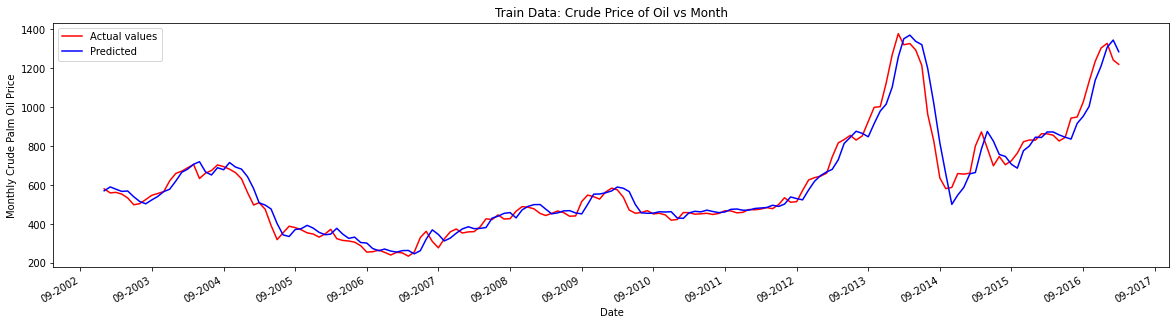

In [134]:
plt.figure(figsize=(20,5))
plt.plot(trainActualRNN, color='red', label='Actual values')
plt.plot(trainPredictdfRNN, color='blue', label='Predicted')
plt.title('Train Data: Crude Price of Oil vs Month')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.xlabel('Date')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.legend(loc='best')

###Create Dataframes for RNN Actual Values and Predicted Values of Test Data

In [135]:
#Create a dataframe for RNN_predictions
rnn_predictions = pd.DataFrame(testPredictRNN, columns = ['rnn_pred'])
#---save rnn_predictions---
#rnnpred_save = df.to_pickle('rnn_pred.pkl')

#---load---
#rnnpred_read = pd.read_pickle('rnn_pred.pkl')
#rnn_predictions.head()

In [136]:
#Reshape testYRNN
testYRNN = testYRNN.reshape(-1,1)

In [137]:
#Create a dataframe for testYRNN
testYRNN  = pd.DataFrame(testYRNN, columns = ['Actual'])

###Plot the RNN Forecasted Values

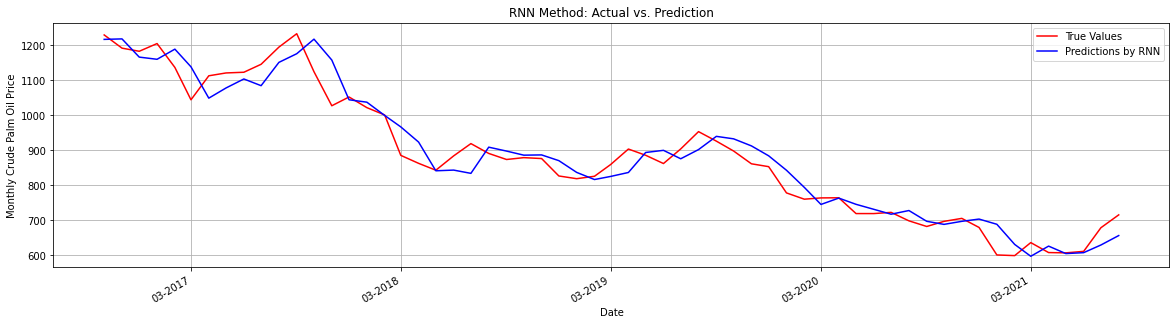

<Figure size 432x288 with 0 Axes>

In [138]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(df_test.index, testYRNN, color = 'red',  label = 'Test')
plt.plot(df_test.index, rnn_predictions, color = 'blue',label = 'MLP Prediction')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(['True Values', 'Predictions by RNN', 'RNN Prediction'],loc='best')
plt.title('RNN Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()
plt.savefig('/content/RNN_UZI.png')

###Evaluate the RNN model

In [139]:
MAE_rnn = mean_absolute_error(testYRNN, rnn_predictions)
print('MAE value of RNN is:', MAE_rnn.round(2))

MAPE_rnn = MAPE(testYRNN, rnn_predictions)
print('MAPE value RNN is', round(MAPE_rnn,2))

MSE_rnn = mean_squared_error(testYRNN, rnn_predictions)
print('MSE value of RNN is:', round(MSE_rnn, 2))

RMSE_rnn = math.sqrt(mean_squared_error(testYRNN, rnn_predictions))
print('RMSE value RNN is: RMSE', round(RMSE_rnn, 2))

MAE value of RNN is: 35.23
MAPE value RNN is 3.99
MSE value of RNN is: 2016.67
RMSE value RNN is: RMSE 44.91


In [140]:
#Save RNN prediction to csv
rnn_predictions.to_csv(r'/content/rnn_predictions.csv')

##Results

In [141]:
#Load series_test
series_test = pd.read_csv('series_test.csv')
series_test.columns = ['Date','cpo_pri']
series_test.reset_index(inplace=True)
del series_test['index']

In [142]:
series_test.head()

,Date,cpo_pri
0,2016-10-01,1230.12
1,2016-11-01,1192.38
2,2016-12-01,1183.45
3,2017-01-01,1205.48
4,2017-02-01,1137.25


In [ ]:
#Load Naive forecast pred
NF_pred = pd.read_csv('NF.csv')
NF_pred.columns = ['Date','NF']
NF_pred.head()

In [144]:
#Load Arima pred
#df.to_csv(r'/content/arima_pred.csv')
arima_pred = pd.read_csv('arima_pred.csv')
arima_pred.columns = ['Date','arima_pred']
arima_pred.head()

FileNotFoundError: ignored

In [153]:
#Merge series_test, arima_pred, mlp_predictions, lstm_predictions, and rnn_predictions dataframes
Result = pd.concat([series_test, NF_pred, arima_pred, mlp_predictions, lstm_predictions, rnn_predictions], axis = 1, join = 'inner')
display(Result)

,Date,cpo_pri,Date,NF,Date,arima_pred,mlp_pred,lstm_pred,rnn_pred
0,2016-10-01,1230.12,2016-10-01,1219.61,2016-10-01,1213.523285,1238.954346,1168.502441,1217.227661
1,2016-11-01,1192.38,2016-11-01,1219.61,2016-11-01,1147.244479,1232.688843,1193.805786,1216.591797
2,2016-12-01,1183.45,2016-12-01,1219.61,2016-12-01,1078.497630,1211.341675,1104.050293,1166.646851
3,2017-01-01,1205.48,2017-01-01,1219.61,2017-01-01,1002.874535,1192.126465,1134.707397,1160.859985
4,2017-02-01,1137.25,2017-02-01,1219.61,2017-02-01,923.396826,1189.844238,1183.165649,1188.274170
5,2017-03-01,1044.75,2017-03-01,1219.61,2017-03-01,862.345210,1169.792236,1023.658508,1138.492920
6,2017-04-01,1113.38,2017-04-01,1219.61,2017-04-01,873.386587,1128.502686,928.471069,1050.527832
7,2017-05-01,1121.50,2017-05-01,1219.61,2017-05-01,915.662351,1119.416992,1161.271118,1078.188721
8,2017-06-01,1123.50,2017-06-01,1219.61,2017-06-01,962.382005,1114.098877,1091.484741,1102.338623
9,2017-07-01,1146.25,2017-07-01,1219.61,2017-07-01,961.991651,1108.992310,1090.164185,1086.957642


In [154]:
#Remove duplicate column
Result = Result.loc[:,~Result.columns.duplicated()]

In [155]:
Result.head()

,Date,cpo_pri,NF,arima_pred,mlp_pred,lstm_pred,rnn_pred
0,2016-10-01,1230.12,1219.61,1213.523285,1238.954346,1168.502441,1217.227661
1,2016-11-01,1192.38,1219.61,1147.244479,1232.688843,1193.805786,1216.591797
2,2016-12-01,1183.45,1219.61,1078.497630,1211.341675,1104.050293,1166.646851
3,2017-01-01,1205.48,1219.61,1002.874535,1192.126465,1134.707397,1160.859985
4,2017-02-01,1137.25,1219.61,923.396826,1189.844238,1183.165649,1188.274170


In [156]:
#Save Result to csv file
df.to_csv('/content/Result.csv')

###Interactive Plot 

####Comparison of Naive Forecast, ARIMA, MLP, LSTM, and RNN Results


In [125]:
from bokeh.plotting import figure, output_file, show
 
fig1=figure(plot_width=500,plot_height=400,
         title="Line Graph of 2x+1",
         title_location="above")

x= [0,1,2,3,4]
y= [1,3,5,7,9]


fig1.title.text_color="orange"
fig1.title.text_font_style="bold"
fig1.line(x,y)


output_file("graph.html")

show(fig1)

In [167]:
#The predicted and actual values using ARIMA, MLP, LSTM, and RNN.
import plotly.graph_objects as go

df_wide = Result
df_long = pd.melt(Result, id_vars=['Date'], value_vars=['cpo_pri','NF','arima_pred', 'mlp_pred', 'lstm_pred', 'rnn_pred'])

# plotly 
fig = px.line(df_long, x='Date', y='value', color='variable', title="NF, ARIMA, MLP, LSTM RNN Results Plot")
fig.show()
fig.write_html("dis_all.html")
#plt.savefig('/content/DIS_ALL.png')
#fig.show(renderer="colab")

#p = figure(plot_width=600, plot_height=450, title = "'Offensive vs. Defensive Eff'")

In [158]:
pandas_bokeh.output_notebook()
df_wide.plot_bokeh(kind='line')
fig.write_html("bokeh_all.html")
#plt.savefig('/content/Bokeh_ALL.png')

###RMSE Comparison Among Different Methods

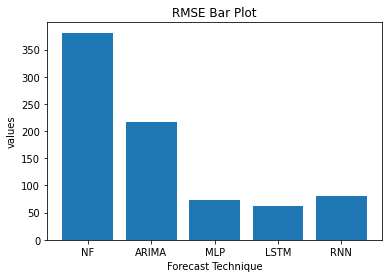

In [198]:
import matplotlib.pyplot as plt 
a_dictionary = {"NF":380.89, "ARIMA": 215.8, "MLP": 72.66, "LSTM": 62.48, "RNN": 80.59}
keys = a_dictionary.keys()
values = a_dictionary.values()
plt.bar(keys, values)
plt.xlabel("Forecasting Method")
plt.ylabel("Value")
plt.title("RMSE")
plt.savefig('/content/RMSE_comp.png')
plt.title('RMSE Bar Plot')
plt.xlabel('Forecast Technique')
plt.ylabel('values')
plt.show()

In [189]:
Met_comp = pd.DataFrame({'Technique': ['Naive Forecast','ARIMA', 'MLP', 'LSTM', 'RNN'], 
                   'MAE': [335.44, 192.44, 59.88, 47.88, 65.19], 'MAPE': [43.83, 24.21, 6.98, 5.16,7.13], 
                   'MSE': [145075.04, 46568.73, 5279.09, 3903.01,6494.47], 'RMSE': [380.89, 215.8, 72.66, 62.48,80.59]})


In [202]:
Met_comp = pd.DataFrame(Met_comp)
print(Met_comp)

        Technique     MAE   MAPE        MSE    RMSE
0  Naive Forecast  335.44  43.83  145075.04  380.89
1           ARIMA  192.44  24.21   46568.73  215.80
2             MLP   59.88   6.98    5279.09   72.66
3            LSTM   47.88   5.16    3903.01   62.48
4             RNN   65.19   7.13    6494.47   80.59


##Conclusion
The model with the lowest RMSE of error is the best predictive model: the RMSE Bar Plot and Metrics Comparison Table show the investigation results. Therefore, based on the RMSE comp figure and Met_comp table results, the LSTM model offers the lowest error value than the Arima, MLP, and RNN models. Thus, the results of this study show that the LSTM-based forecasting model is superior to other models in predicting price fluctuations in the crude price of oil.